In [56]:
# For data wrangling
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# For creating plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [155]:
# Data Pull
df_ot = pd.read_excel(r'D:\Projects\Rentals\rental_data_ottawa_1.xlsx')
df_to = pd.read_excel(r'D:\Projects\Rentals\rental_data_toronto_1.xlsx')

# Combine dataframes into one
df = pd.concat([df_ot, df_to], axis=0, ignore_index=True)

# Display the count of the DataFrames
print("Number of Rows in Ottawa Data:", df_ot.shape[0])
print("Number of Rows in Ottawa Data:", df_to.shape[0])
print("Number of Rows in Combined Data:", df.shape[0])

Number of Rows in Ottawa Data: 805
Number of Rows in Ottawa Data: 920
Number of Rows in Combined Data: 1725


In [167]:
df_to["Bedrooms"].unique()

array(['0-3', '1-2', '1-3', '0-2.5', '1-2.5', '0-2', '0-1.5', '2', '1',
       '2.5', '1.5', '0-1', '3', '0', '652', '912', '510', '550', '1-1.5',
       '980', '1200', '650', '950', '850', '1.5-2.5', '1.5-2', '3.5',
       '443', '1170', '722', '870', '562', '961', '649', '629', '600',
       '620', '0-3.5', '856', '411', '804', '297', '664', '621', '640',
       '964', '500', '910', '603', '743', '1304', '597', '3037', '2416',
       '387', '614', '986', '800', '924', '1000', '717', '1158', '900',
       '0.5', '700', '0.5-2', '4', '390', '499', '599', '418', '647',
       '584', '5', '685', '560', '809', '1050', '380', '2500', '1500',
       '1688', '1150', '1148', '920', '1970', '545', '1100', '680', '820',
       nan], dtype=object)

## Data Clean-Up

#### Fix incorrect or missing Cities

In [157]:
#print( df[df["City"] =="City not found"].head(5))
print( df[df["Bathrooms"] != "-"].head(5))

             City Property Type Bedrooms Bathrooms Square Footage                                Address Zip code          Price
0          Ottawa     apartment      1-2         2            856            90 Champagne  - Ottawa , ON  K1S 4P1  $2100 - $2900
1  City not found     apartment      0-1         1            0-1   253 - 257 York Street  - Ottawa , ON  K1N 5T9  $1675 - $1850
2  City not found     apartment        1       756              1            86-92 Hinton  - Ottawa , ON  K1Y 2Z7  $1700 - $2200
3  City not found     apartment        1       167            0-2  150-152 Osgoode Street  - Ottawa , ON  K1N 8A4          $1400
4          Ottawa     apartment        1       470            1-2              256 Rideau  - Ottawa , ON  K1N 0A9  $1375 - $2500


In [191]:
# Fix the missing cities

def update_city(row):
    address = row['Address'].lower()  # Convert address to lowercase for case-insensitive matching
    if 'ottawa' in address or 'nepean' in address or 'gloucester' in address:
        return 'Ottawa'
    elif 'toronto' in address or 'east york' in address or 'richmond' in address or 'north york' in address or 'york' in address or 'scarborough' in address or 'etobicoke' in address:
        return 'Toronto'
    return row['City']

# Apply the custom function to update the "City" column
df['City'] = df.apply(update_city, axis=1)

# Display the updated DataFrame
#print(df.head())
print(len(df["Zip code"]))

1725


#### Incorrect data was placed in the Bedroom Bathrom and SQ FT columns. Need to clean and correct

In [211]:
# Create dictionaries for each column
incorrect = {}
incorrect_bed = {}
incorrect_bath = {}
incorrect_sqft = {}

incorrect_bed = dict(zip(df["Zip code"],df["Bedrooms"]))
incorrect_bath=  dict(zip(df["Zip code"],df["Bathrooms"]))
incorrect_sqft = dict(zip(df["Zip code"],df["Square Footage"]))
#incorrect = incorrect_bed.copy()
#incorrect.update(incorrect_bath)
#incorrect.update(incorrect_sqft)

# Create an empty 'incorrect' dictionary
incorrect = {}

# Iterate through the keys in 'incorrect_bed'
for key in incorrect_bed:
    incorrect[key] = [incorrect_bed[key], incorrect_bath.get(key), incorrect_sqft.get(key)]



print(len(incorrect_bed))
print(len(incorrect_bath))
print(len(incorrect_sqft))
print(len(incorrect))

838
838
838
838


In [189]:
# Define the key you want to filter for
target_key = 'K1S 4P1'

# Check if the target key exists in the dictionary
if target_key in incorrect:
    filtered_dict = {target_key: incorrect[target_key]}
else:
    filtered_dict = {}

# Display the filtered dictionary
print(filtered_dict)

{'K1S 4P1': nan}


In [206]:
unique_zip_codes = df["Zip code"].unique()
duplicated_zip_codes = df["Zip code"][df["Zip code"].duplicated()].unique()
zip_code_counts = df["Zip code"].value_counts()
zip_codes_appearing_more_than_twice = zip_code_counts[zip_code_counts > 2]
zip_codes_appearing_more_than_once = zip_code_counts[zip_code_counts > 2]

dict3 = unique_zip_codes.copy()

# Remove elements from dict3 that appear in dict2
for key in zip_codes_appearing_more_than_once.keys():
    if key in dict3:
        del dict3[key]

# Display the modified dict3
print(len(dict3))




print(len(unique_zip_codes))
print(len(duplicated_zip_codes))
print(len(duplicated_zip_codes)*2)
print(len(zip_codes_appearing_more_than_twice))
print(len(zip_codes_appearing_more_than_twice)-(len(unique_zip_codes)))



ValueError: cannot delete array elements

#### Split Price to have a Minimum, Maximum, and Average Price

In [160]:
# Define a function to clean and reorganize the data
df_2 = df.copy()
def clean_and_reorganize(row):
    bedrooms = row['Bedrooms']
    bathrooms = row['Bathrooms']
    sq_ft = row['Square Footage']
    
    # Check if any column contains data with "-"
    if any('-' in str(val) for val in row):
        bedrooms = '-'
        bathrooms = '-'
        sq_ft = '-'
    else:
        # Define the conditions, handling numeric and string values
        bedrooms_val = row['Bedrooms']
        bathrooms_val = row['Bathrooms']
        
        # Check if values are numeric or can be converted to numeric
        if isinstance(bedrooms_val, (int, float)) and 0 <= bedrooms_val <= 5:
            bedrooms = bedrooms_val
        elif isinstance(bathrooms_val, (int, float)) and 0.5 <= bathrooms_val <= 3:
            bathrooms = bathrooms_val
        else:
            # If neither condition is met, assign data to sq_ft
            sq_ft_val = row['Square Footage']
            if isinstance(sq_ft_val, (int, float)):
                sq_ft = sq_ft_val
            elif sq_ft_val.replace('.', '', 1).isdigit():
                sq_ft = float(sq_ft_val)
    
    return pd.Series([bedrooms, bathrooms, sq_ft])

# Apply the function to each row
df_2[['Cleaned Bedrooms', 'Cleaned Bathrooms', 'Cleaned Square Footage']] = df_2.apply(clean_and_reorganize, axis=1)

# Display the DataFrame with cleaned columns
print(df_2)


         City Property Type Bedrooms Bathrooms Square Footage                                Address Zip code          Price Cleaned Bedrooms Cleaned Bathrooms Cleaned Square Footage
0      Ottawa     apartment      1-2         2            856            90 Champagne  - Ottawa , ON  K1S 4P1  $2100 - $2900                -                 -                      -
1      Ottawa     apartment      0-1         1            0-1   253 - 257 York Street  - Ottawa , ON  K1N 5T9  $1675 - $1850                -                 -                      -
2      Ottawa     apartment        1       756              1            86-92 Hinton  - Ottawa , ON  K1Y 2Z7  $1700 - $2200                -                 -                      -
3      Ottawa     apartment        1       167            0-2  150-152 Osgoode Street  - Ottawa , ON  K1N 8A4          $1400                -                 -                      -
4      Ottawa     apartment        1       470            1-2              256 Rideau

In [ ]:
filtered_bed = df[df['Bedrooms'] > 0]['Bedrooms']
filtered_bath = df[df['Bathrooms'] > 0]['Bathrooms']
filtered_sqft = df[df['Square Footage'] > 0]['Square Footage']


print("max bed:", filtered_bed.nlargest(3).tolist())
print("min bed:",filtered_bed.nsmallest(3).tolist())
print("max bath:",filtered_bath.nlargest(3).tolist())
print("min bath:",filtered_bath.nsmallest(3).tolist())
print("max sq ft:",filtered_sqft.nlargest(3).tolist())
print("min sq ft:",filtered_sqft.nsmallest(3).tolist())

In [87]:
# Split the Price column into two columns
df[['MinPrice', 'MaxPrice']] = df['Price'].str.split('-', expand=True)

# Strip whitespace and remove the dollar sign from the columns
df['MinPrice'] = df['MinPrice'].str.strip().str.replace('$', '').astype(float)
df['MaxPrice'] = df['MaxPrice'].str.strip().str.replace('$', '').astype(float)

# Calculate the average of Price1 and Price2, handling missing values
df['Average_Price'] = df[['MinPrice', 'MaxPrice']].mean(axis=1, skipna=True)


# Display the updated DataFrame
print(df.head())

     City Property Type Bedrooms Bathrooms Square Footage                             Address Zip code          Price  MinPrice  MaxPrice  Average_Price
0  Ottawa     apartment        1         1              1  335 MacLaren Street  - Ottawa , ON  K2P 0M7  $1750 - $1775    1750.0    1775.0         1762.5
1  Ottawa     apartment        1       1-2              2     360 Frank Street  - Ottawa , ON  K2P 1Y7          $1750    1750.0       NaN         1750.0
2  Ottawa     apartment      670       1-3            1.5    638 Center Street  - Ottawa , ON  K1K 4S5  $1740 - $2325    1740.0    2325.0         2032.5
3  Ottawa     apartment        5         2              5  460 St-Laurent blvd  - Ottawa , ON  K1K 2Z8  $1805 - $3560    1805.0    3560.0         2682.5
4  Ottawa     apartment        1         0              1         323 Besserer  - Ottawa , ON  K1N 1C7          $4250    4250.0       NaN         4250.0


#### Split Bedroom column to have a Minimum, Maximum, and Average Bedroom number

In [88]:
# Split the Price column into two columns
df[['Min_Bed', 'Max_Bed']] = df['Bedrooms'].str.split('-', expand=True)

# Strip whitespace and remove the dollar sign from the columns
df['Min_Bed'] = df['Min_Bed'].str.strip().str.replace('$', '').astype(float)
df['Max_Bed'] = df['Max_Bed'].str.strip().str.replace('$', '').astype(float)

# Calculate the average of Price1 and Price2, handling missing values
df['Average_Bed'] = df[['Min_Bed', 'Max_Bed']].mean(axis=1, skipna=True)


# Display the updated DataFrame
print(df.head())

     City Property Type Bedrooms Bathrooms Square Footage                             Address Zip code          Price  MinPrice  MaxPrice  Average_Price  Min_Bed  Max_Bed  Average_Bed
0  Ottawa     apartment        1         1              1  335 MacLaren Street  - Ottawa , ON  K2P 0M7  $1750 - $1775    1750.0    1775.0         1762.5      1.0      NaN          1.0
1  Ottawa     apartment        1       1-2              2     360 Frank Street  - Ottawa , ON  K2P 1Y7          $1750    1750.0       NaN         1750.0      1.0      NaN          1.0
2  Ottawa     apartment      670       1-3            1.5    638 Center Street  - Ottawa , ON  K1K 4S5  $1740 - $2325    1740.0    2325.0         2032.5    670.0      NaN        670.0
3  Ottawa     apartment        5         2              5  460 St-Laurent blvd  - Ottawa , ON  K1K 2Z8  $1805 - $3560    1805.0    3560.0         2682.5      5.0      NaN          5.0
4  Ottawa     apartment        1         0              1         323 Besserer  

#### Split Bathroom column to have a Minimum, Maximum, and Average Bedroom number

In [89]:
# Split the Price column into two columns
df[['Min_Bath', 'Max_Bath']] = df['Bathrooms'].str.split('-', expand=True)

# Strip whitespace and remove the dollar sign from the columns
df['Min_Bath'] = df['Min_Bath'].str.strip().str.replace('$', '').astype(float)
df['Max_Bath'] = df['Max_Bath'].str.strip().str.replace('$', '').astype(float)

# Calculate the average of Price1 and Price2, handling missing values
df['Average_Bath'] = df[['Min_Bath', 'Max_Bath']].mean(axis=1, skipna=True)


# Display the updated DataFrame
print(df.head())

     City Property Type Bedrooms Bathrooms Square Footage                             Address Zip code          Price  MinPrice  MaxPrice  Average_Price  Min_Bed  Max_Bed  Average_Bed  Min_Bath  Max_Bath  Average_Bath
0  Ottawa     apartment        1         1              1  335 MacLaren Street  - Ottawa , ON  K2P 0M7  $1750 - $1775    1750.0    1775.0         1762.5      1.0      NaN          1.0       1.0       NaN           1.0
1  Ottawa     apartment        1       1-2              2     360 Frank Street  - Ottawa , ON  K2P 1Y7          $1750    1750.0       NaN         1750.0      1.0      NaN          1.0       1.0       2.0           1.5
2  Ottawa     apartment      670       1-3            1.5    638 Center Street  - Ottawa , ON  K1K 4S5  $1740 - $2325    1740.0    2325.0         2032.5    670.0      NaN        670.0       1.0       3.0           2.0
3  Ottawa     apartment        5         2              5  460 St-Laurent blvd  - Ottawa , ON  K1K 2Z8  $1805 - $3560    1805.0 

In [90]:
# Reorganize Columns
desired_column_order =['City', 'Property Type', 'Bedrooms','Average_Bed', 'Bathrooms', 
                       'Average_Bath', 'Square Footage', 'Address', 'Zip code', 'Price',
                       'Average_Price', 'MinPrice', 'MaxPrice', 'Min_Bed','Max_Bed',  
                       'Min_Bath', 'Max_Bath']
df = df[desired_column_order]

# Convert columns to numeric data types, replacing non-numeric values with NaN
numeric_columns = ['Square Footage', 'Bedrooms', 'Bathrooms', 'Price']
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Check for missing values (NaN)
print(df.isnull().sum())

print(df.head())

City                 0
Property Type        0
Bedrooms           260
Average_Bed        111
Bathrooms          188
Average_Bath       147
Square Footage     294
Address              0
Zip code             0
Price             1607
Average_Price        0
MinPrice             0
MaxPrice          1279
Min_Bed            111
Max_Bed           1458
Min_Bath           147
Max_Bath          1566
dtype: int64
     City Property Type  Bedrooms  Average_Bed  Bathrooms  Average_Bath  Square Footage                             Address Zip code  Price  Average_Price  MinPrice  MaxPrice  Min_Bed  Max_Bed  Min_Bath  Max_Bath
0  Ottawa     apartment       1.0          1.0        1.0           1.0             1.0  335 MacLaren Street  - Ottawa , ON  K2P 0M7    NaN         1762.5    1750.0    1775.0      1.0      NaN       1.0       NaN
1  Ottawa     apartment       1.0          1.0        NaN           1.5             2.0     360 Frank Street  - Ottawa , ON  K2P 1Y7    NaN         1750.0    1750.0      

In [104]:
# Save as an excel file to be mapped on Tableau
column_drop = ['MinPrice','MaxPrice','Min_Bed','Max_Bed','Min_Bath','Max_Bath','Bedrooms','Bathrooms']
x_df = df.copy()
x_df['Country'] = 'Canada'
x_df.drop(columns = column_drop, inplace=True )
x_df.reset_index(drop=False)

# Pull Excel file that contains geodata



x_df.to_excel("rental_data_clean.xlsx",index=False)
x_df.columns

Index(['City', 'Property Type', 'Average_Bed', 'Average_Bath', 'Square Footage', 'Address', 'Zip code', 'Price', 'Average_Price', 'Country'], dtype='object')

## Plots

In [71]:
# Unique Column Names
df.columns

Index(['City', 'Property Type', 'Bedrooms', 'Average_Bed', 'Bathrooms', 'Average_Bath', 'Square Footage', 'Address', 'Zip code', 'Price', 'Average_Price', 'MinPrice', 'MaxPrice', 'Min_Bed', 'Max_Bed', 'Min_Bath', 'Max_Bath'], dtype='object')

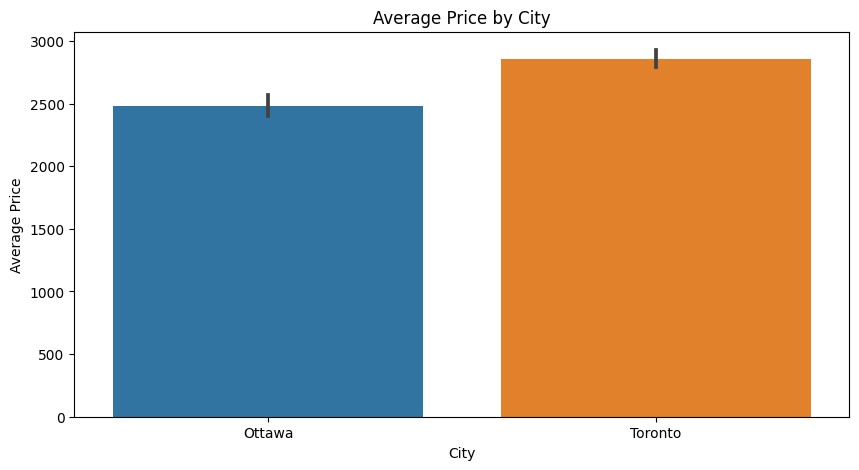

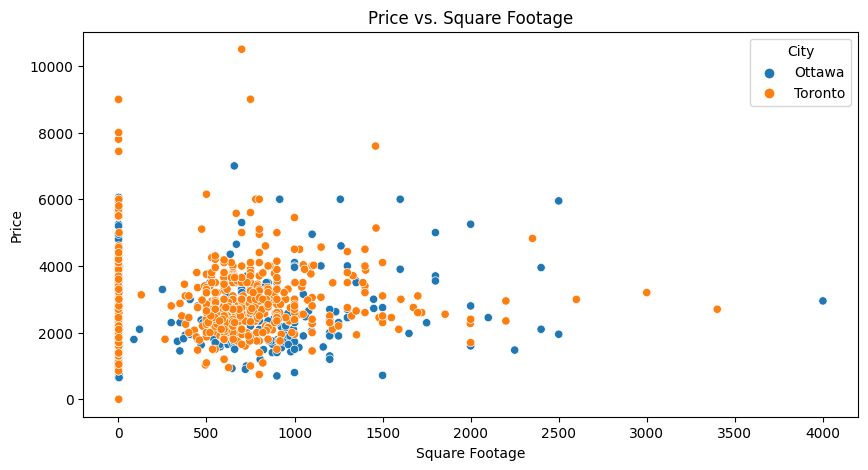

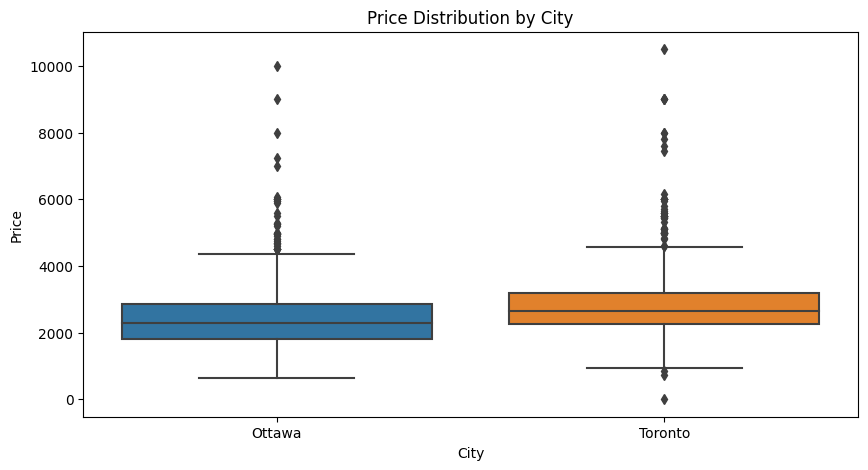

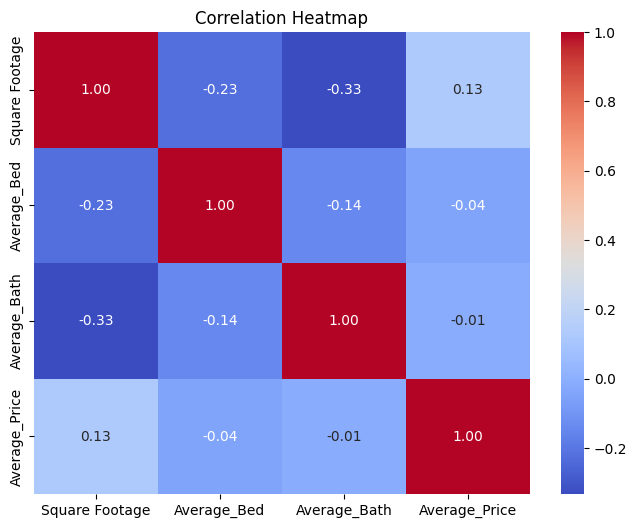

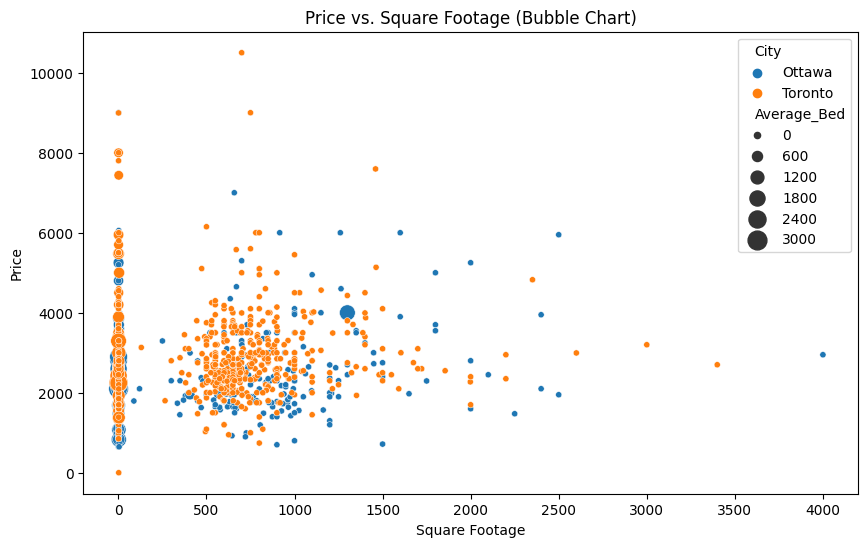

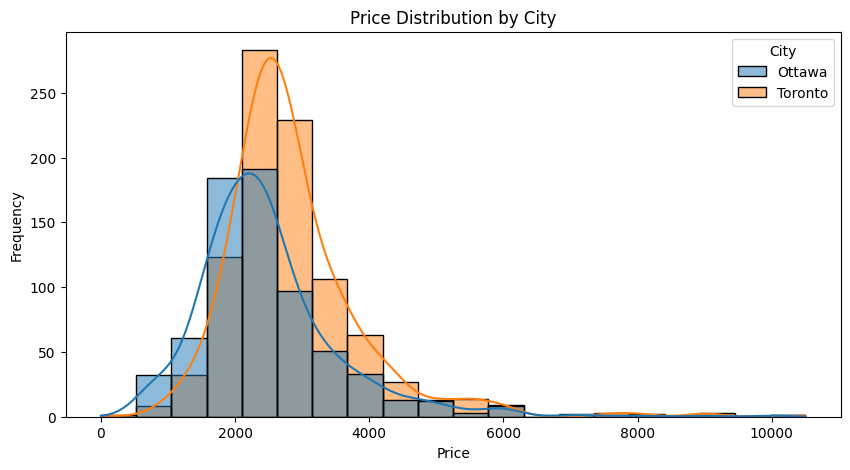

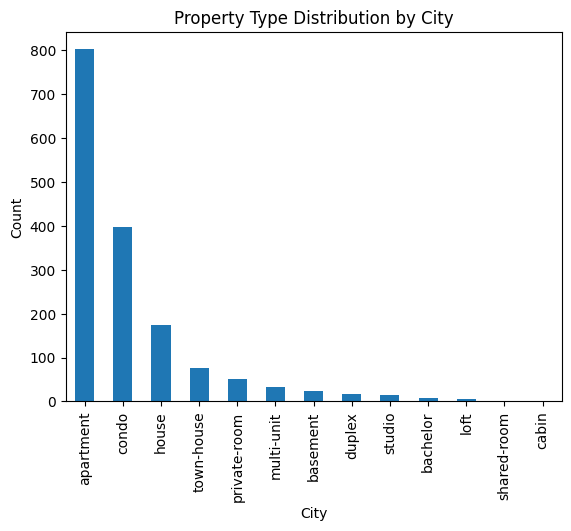

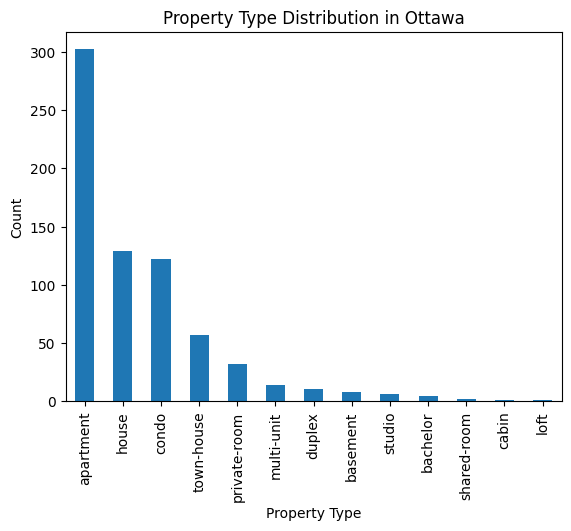

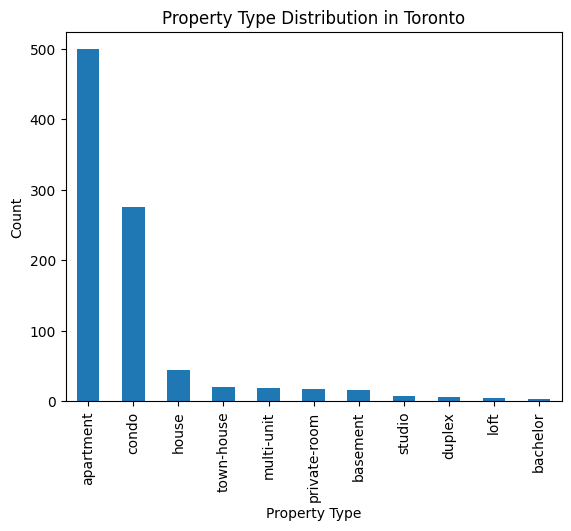

In [66]:
# 1. Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x='City', y='Average_Price', data=df)
plt.title('Average Price by City')
plt.xlabel('City')
plt.ylabel('Average Price')
plt.show()

# 2. Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Square Footage', y='Average_Price', data=df, hue='City')
plt.title('Price vs. Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Price')
plt.show()

# 3. Box Plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='City', y='Average_Price', data=df)
plt.title('Price Distribution by City')
plt.xlabel('City')
plt.ylabel('Price')
plt.show()

# 4. Heatmap (Correlation)
correlation_matrix = df[['Square Footage', 'Average_Bed', 'Average_Bath', 'Average_Price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 5. Line Plot (Assuming you have time-related data)
# Here, you would need time-related data for this plot, which is not available in the provided columns.

# 6. Bubble Chart
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Square Footage', y='Average_Price', data=df, hue='City', size='Average_Bed', sizes=(20, 200))
plt.title('Price vs. Square Footage (Bubble Chart)')
plt.xlabel('Square Footage')
plt.ylabel('Price')
plt.show()

# 7. Histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Average_Price', bins=20, kde=True, hue='City')
plt.title('Price Distribution by City')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 8. Stacked Bar Chart - Average
df['Property Type'].value_counts().plot(kind='bar', stacked=True)
plt.title('Property Type Distribution by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

# 9. Stacked Bar Chart - Per City
# Get unique city names
unique_cities = df['City'].unique()

# Create a stacked bar chart for each city
for city in unique_cities:
    city_data = df[df['City'] == city]
    property_type_counts = city_data['Property Type'].value_counts()
    
    # Create a stacked bar chart for the current city
    property_type_counts.plot(kind='bar', stacked=True)
    plt.title(f'Property Type Distribution in {city}')
    plt.xlabel('Property Type')
    plt.ylabel('Count')
    plt.show()